In [45]:
import os
from ast import literal_eval

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [2]:
credits = pd.read_csv(os.path.join('/', 'Users', 'yjkim', 'data', 'recommend',
                                  'tmdb', 'tmdb_5000_credits.csv'))
movies = pd.read_csv(os.path.join('/', 'Users', 'yjkim', 'data', 'recommend',
                                 'tmdb', 'tmdb_5000_movies.csv'))

In [3]:
credits.columns = ['id', 'title', 'cast', 'crew']
credits = credits.drop(columns=['title'])
movies = movies.merge(credits, on='id', right_index=False)

In [4]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')

In [5]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."


#### Demograpic Filtering

In [6]:
C = movies['vote_average'].mean()
C

6.092171559442016

In [7]:
m = movies['vote_count'].quantile(0.9)
m

1838.4000000000015

In [8]:
q_movies = movies.copy().loc[movies['vote_count'] >= m ]
q_movies.shape

(481, 22)

In [9]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    
    return (v/(v+m) * R) + (m/(m+v) * C)

In [10]:
# Define a new feature 'score' and calculate its value with 'weighted_rating()'
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [11]:
# Sort movies based on score calculated above
q_movies = q_movies.sort_values(by=['score'], ascending=False)

# Print the top 15 movies
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


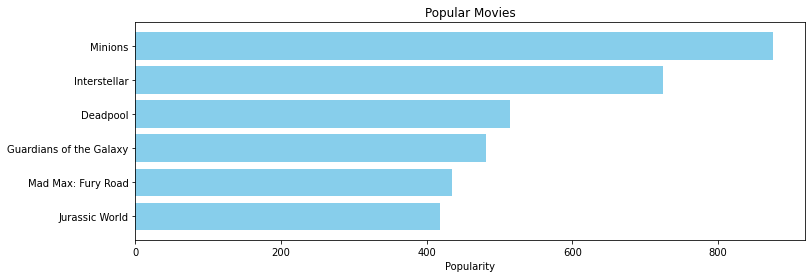

In [12]:
pop = movies.sort_values('popularity', ascending=False)

plt.figure(figsize=(12,4))
plt.barh(pop['title'].head(6), pop['popularity'].head(6), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")
plt.show()

#### Content Based Filtering

In [13]:
# Plot description based Recommender

In [14]:
movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [15]:
# compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview

In [16]:
# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

# Replace Nan with an empty string
movies['overview'] = movies['overview'].fillna('')

# Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['overview'])

# Output the shape of tfidf_matrix
tfidf_matrix.shape

(4803, 20978)

In [17]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [18]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [19]:
# Define recommendation function
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1: 11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    return movies['title'].iloc[movie_indices]

In [20]:
get_recommendations('The Dark Knight Rises')

65                              The Dark Knight
299                              Batman Forever
428                              Batman Returns
1359                                     Batman
3854    Batman: The Dark Knight Returns, Part 2
119                               Batman Begins
2507                                  Slow Burn
9            Batman v Superman: Dawn of Justice
1181                                        JFK
210                              Batman & Robin
Name: title, dtype: object

#### Credits, Genres and Keywords Based Recommender

In [21]:
# Parse the stringfied features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [22]:
# Get the director's name from the crew features. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [23]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [24]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [25]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [26]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        # Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [27]:
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [28]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,237000000,"[action, adventure, fantasy]",http://www.avatarmovie.com/,19995,"[cultureclash, future, spacewar]",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[samworthington, zoesaldana, sigourneyweaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...",jamescameron
1,300000000,"[adventure, fantasy, action]",http://disney.go.com/disneypictures/pirates/,285,"[ocean, drugabuse, exoticisland]",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[johnnydepp, orlandobloom, keiraknightley]","[{'credit_id': '52fe4232c3a36847f800b579', 'de...",goreverbinski
2,245000000,"[action, adventure, crime]",http://www.sonypictures.com/movies/spectre/,206647,"[spy, basedonnovel, secretagent]",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[danielcraig, christophwaltz, léaseydoux]","[{'credit_id': '54805967c3a36829b5002c41', 'de...",sammendes


In [29]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast'])  + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

In [30]:
movies['soup'] = movies.apply(create_soup, axis=1)

In [31]:
movies[['keywords', 'cast', 'director', 'soup']].head(3)

,keywords,cast,director,soup
0,"[cultureclash, future, spacewar]","[samworthington, zoesaldana, sigourneyweaver]",jamescameron,cultureclash future spacewar samworthington zo...
1,"[ocean, drugabuse, exoticisland]","[johnnydepp, orlandobloom, keiraknightley]",goreverbinski,ocean drugabuse exoticisland johnnydepp orland...
2,"[spy, basedonnovel, secretagent]","[danielcraig, christophwaltz, léaseydoux]",sammendes,spy basedonnovel secretagent danielcraig chris...


In [32]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [33]:
# Compute the Cosine Similarity matrix based on the count_matrix
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [34]:
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [35]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

65               The Dark Knight
119                Batman Begins
4638    Amidst the Devil's Wings
1196                The Prestige
3073           Romeo Is Bleeding
3326              Black November
1503                      Takers
1986                      Faster
303                     Catwoman
747               Gangster Squad
Name: title, dtype: object

We see that our recommender has been successful in capturing more information due to more metadata and has given us (arguably) better recommendations. It is more likely that Marvels or DC comics fans will like the movies of the same production house. Therefore, to our features above we can add production_company . We can also increase the weight of the director , by adding the feature multiple times in the soup.

### Collaborative Filtering

- **User based filtering**
 
 These systems recommend products to a user that similar users have liked. For measuring the similarity between two users we can either use pearson correlation or cosine similarity. This filtering technique can be illustrated with an example. In the following matrixes, each row represents a user, while the columns correspond to different movies except the last one which records the similarity between that user and the target user. Each cell represents the rating that the user gives to that movie. Assume user E is the target 
  
 Although computing user-based CF is very simple, it suffers from several problems. One main issue is that users’ preference can change over time. It indicates that precomputing the matrix based on their neighboring users may lead to bad performance. To tackle this problem, we can apply item-based CF.

- **Item Based Collaborative Filtering**
 
 Instead of measuring the similarity between users, the item-based CF recommends items based on their similarity with the items that the target user rated. Likewise, the similarity can be computed with Pearson Correlation or Cosine Similarity. The major difference is that, with item-based collaborative filtering, we fill in the blank vertically, as oppose to the horizontal manner that user-based CF does. The following table shows how to do so for the movie Me Before You.
 
 It successfully avoids the problem posed by dynamic user preference as item-based CF is more static. However, several problems remain for this method. First, the main issue is **scalability**. The computation grows with both the customer and the product. The worst case complexity is O(mn) with m users and n items. In addition, **sparsity** is another concern. Take a look at the above table again. Although there is only one user that rated both Matrix and Titanic rated, the similarity between them is 1. In extreme cases, we can have millions of users and the similarity between two fairly different movies could be very high simply because they have similar rank for the only user who ranked them both

#### Single Values Decomposition
 
One way to handle the scalability and sparsity issue created by CF is to leverage a **latent factor model** to capture the similarity between users and items. Essentially, we want to turn the recommendation problem into an optimization problem. We can view it as how good we are in predicting the rating for items given a user. One common metric is Root Mean Square Error (RMSE). **The lower the RMSE, the better the performance.**

In [40]:
reader = Reader()
ratings = pd.read_csv(os.path.join('/', 'Users', 'yjkim', 'data', 'recommend', 
                                   'the-movies-dataset', 'ratings_small.csv'))
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [46]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd= SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5)

{'test_rmse': array([0.89600055, 0.89627738, 0.90205339, 0.89377058, 0.89657231]),
 'test_mae': array([0.69192925, 0.68963525, 0.69362327, 0.68690906, 0.69079154]),
 'fit_time': (5.2189040184021,
  5.29066276550293,
  5.413956165313721,
  5.222956657409668,
  5.095553874969482),
 'test_time': (0.24125909805297852,
  0.17841601371765137,
  0.18073701858520508,
  0.2489762306213379,
  0.15453314781188965)}

In [47]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [48]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [53]:
# predict(userId, moiveId, rating)
svd.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.6925420549648824, details={'was_impossible': False})

In [56]:
result = svd.predict(1, 2968)

In [61]:
result.est

2.450106026049058